# Test Rosetta's ability to predict effects of mutations at protein-protein interfaces

## Import `Python` modules

In [1]:
import os
import sys
import subprocess
from collections import defaultdict
import pandas as pd
import glob
import random
import re
import shutil
import Bio
from Bio.PDB import PDBList
import Bio.Alphabet
import math
import sklearn.metrics
import time
import numpy as np
import scipy.stats
import umap
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=2, style='ticks', palette='colorblind')

import pyrosetta
pyrosetta.init('-cryst:crystal_refine -read_only_ATOM_entries -mute all')

# custom modules
sys.path.append('scripts/')
import design_utils
import scoring_utils

resultsdir = '/net/scratch/haddox/2024/interface_cart_ddg_benchmark/results/'
if not os.path.isdir(resultsdir):
    os.makedirs(resultsdir)

## Read in data from SKEMPI database

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
ddg_df = pd.read_csv('data/skempi_v2.csv', sep=';')
ddg_df.rename(columns={
    '#Pdb' : 'pdb',
    'Mutation(s)_PDB' : 'mut_pdb',
    'Mutation(s)_cleaned' : 'mut',
    'iMutation_Location(s)' : 'loc',
    'Affinity_mut_parsed': 'kd_mut',
    'Affinity_wt_parsed': 'kd_wt',
    'Temperature': 'temp',
}, inplace=True)
#ddg_df['pdb_id'] = ddg_df['pdb'].apply(lambda x: x[:4])
ddg_df[['pdb_id', 'left_chains', 'right_chains']] = ddg_df['pdb'].str.extract(r'(\w+)_(\w+)_(\w+)')
print('length of initial dataframe', len(ddg_df), ddg_df['pdb'].nunique())
print(len(ddg_df.drop_duplicates(subset=['pdb_id', 'mut_pdb'])))

# Convert temp column to float, removing rows where temp is assumed
ddg_df['temp'] = ddg_df['temp'].astype('str')
ddg_df['temp'] = ddg_df['temp'].apply(lambda x: x.replace('(assumed)', ''))
ddg_df = ddg_df[
    (~ddg_df['temp'].str.contains('assumed')) &
    (ddg_df['temp'].notnull())
]
ddg_df['temp'] = ddg_df['temp'].astype('float')

# Get data for single mutants
ddg_df['nmuts'] = ddg_df['mut'].apply(lambda x: len(x.split(',')))
ddg_df = ddg_df[ddg_df['nmuts'] == 1]

# Compute dGs and ddG for each mut
def compute_dg(kd, temp):
    #print(kd, temp)
    #x = kd * float(temp)
    return 1.987e-3 * temp * np.log(kd) #  = kcal/(mol * K) * K = kcal/mol
ddg_df['dg_wt'] = ddg_df.apply(lambda row: compute_dg(row['kd_wt'], row['temp']), axis=1)
ddg_df['dg_mut'] = ddg_df.apply(lambda row: compute_dg(row['kd_mut'], row['temp']), axis=1)
ddg_df['ddg'] = ddg_df['dg_mut'] - ddg_df['dg_wt']

# Add columns giving the wt aa, mut aa, and chain
ddg_df['site'] = ddg_df['mut'].str.extract('(\d+)')
ddg_df[['wt_aa', 'chain', 'site_pdb', 'mut_aa']] = ddg_df['mut_pdb'].str.extract(r'(\w)(\w)-*(\d+)(\w)$')
ddg_df.dropna(subset=['site_pdb'], inplace=True)
ddg_df['wt_aa_site'] = ddg_df['wt_aa'] + ddg_df['site']
ddg_df['wt_aa_site_pdb'] = ddg_df['wt_aa'] + ddg_df['site_pdb']
ddg_df['site'] = ddg_df['site'].astype('int')
ddg_df['site_pdb'] = ddg_df['site_pdb'].astype('int')

# Add a column indicating whether a mutation is to or from a polar
polar_aas = list('DEHKNQRST')
ddg_df['wt_aa_is_polar'] = ddg_df['wt_aa'].isin(polar_aas)
ddg_df['mut_aa_is_polar'] = ddg_df['mut_aa'].isin(polar_aas)
ddg_df['involves_polar'] = ddg_df['wt_aa_is_polar'] | ddg_df['mut_aa_is_polar']

# For each mutation, infer which chain number and jump number to use when running the cart_ddg application
def get_jump_and_chain_n(mut_chain, left_chains, right_chains):

    # sort ids in each chain
    left_chains = sorted(list(left_chains))
    right_chains = sorted(list(right_chains))
    
    # sort the two lists of chain ids and then make a single list with all ids
    # in the order they occur in the sorted chain list
    sorted_chains_lists = sorted((left_chains, right_chains))
    #print(left_chains, right_chains, sorted_chains_lists)
    all_chains = []
    for chains in sorted_chains_lists:
        all_chains += chains
    assert len(all_chains) == len(set(all_chains))
    
    # if ids are still not in alphabetical order (e.g. if left chains is ABP and right chains is CD),
    # then return nan for jump_n and chain_n
    if not (all_chains == sorted(all_chains)):
        return np.nan
        
    # given the id of the mutant chain, get that chain's sequential index in the sorted list
    chain_n = all_chains.index(mut_chain) + 1
    
    # ... and determine the appropriate jump number to use
    jump_n = len(sorted_chains_lists[0])
    #print(all_chains)
    #print(mut_chain, chain_n, jump_n)
    
    return (chain_n, jump_n)

ddg_df['cartddg_chain_and_jump_n'] = ddg_df.apply(
    lambda row: get_jump_and_chain_n(row['chain'], row['left_chains'], row['right_chains']),
    axis=1
)
ddg_df = ddg_df[ddg_df['cartddg_chain_and_jump_n'].notnull()]

print('length of final dataframe', len(ddg_df), ddg_df['pdb'].nunique())

length of initial dataframe 7085 348
6185
length of final dataframe 4971 318


In [4]:
# Identify PDBs where the current strategy for computing jump number doesn't
# seem to work
ddg_df['n_left_chains'] = ddg_df['left_chains'].apply(lambda x: len(x))
ddg_df['n_right_chains'] = ddg_df['right_chains'].apply(lambda x: len(x))
ddg_df['jump_n_problem'] = ddg_df.apply(
    lambda row: row['n_left_chains'] != row['cartddg_chain_and_jump_n'][1],
    axis=1
)
# ddg_df[[
#     'left_chains', 'right_chains', 'n_left_chains', 'cartddg_chain_and_jump_n', 'jump_n_problem'
# ]].sort_values('jump_n_problem')
problem_pdbs = set(ddg_df[ddg_df['jump_n_problem'] == True]['pdb'])
problem_pdbs.update(set(ddg_df[ddg_df['n_right_chains'] > 1]['pdb']))

print('N pdbs to filter', len(problem_pdbs))

N pdbs to filter 71


In [5]:
# ddg_df['polar_to_polar'] = ddg_df['wt_aa_is_polar'] & ddg_df['mut_aa_is_polar']
# ddg_df['polar_to_nonpolar'] = ddg_df['wt_aa_is_polar'] & ~ddg_df['mut_aa_is_polar']
# ddg_df['nonpolar_to_polar'] = ~ddg_df['wt_aa_is_polar'] & ddg_df['mut_aa_is_polar']
# ddg_df['nonpolar_to_nonpolar'] = ~ddg_df['wt_aa_is_polar'] & ~ddg_df['mut_aa_is_polar']

def classify_mutation(wt_aa, mut_aa):
    if (wt_aa in polar_aas) and (mut_aa in polar_aas):
        return 'polar_to_polar'
    elif (wt_aa in polar_aas) and (mut_aa not in polar_aas):
        return 'polar_to_nonpolar'
    elif (wt_aa not in polar_aas) and (mut_aa in polar_aas):
        return 'nonpolar_to_polar'
    elif (wt_aa not in polar_aas) and (mut_aa not in polar_aas):
        return 'nonpolar_to_nonpolar'

ddg_df['mut_category'] = ddg_df.apply(lambda row: classify_mutation(row['wt_aa'], row['mut_aa']), axis=1)

In [6]:
ddg_df['mut_category'].value_counts()

polar_to_nonpolar       2278
nonpolar_to_nonpolar    1540
polar_to_polar           673
nonpolar_to_polar        480
Name: mut_category, dtype: int64

Identify structures to analyze based on how many mutations they have

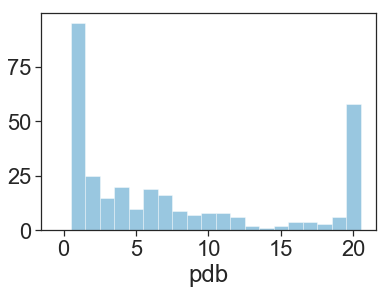

102 4290


3BT1_A_U      245
1A22_A_B      212
1CHO_EFG_I    205
1R0R_E_I      205
3SGB_E_I      204
Name: pdb, dtype: int64

In [7]:
data = ddg_df['pdb'].value_counts()

sns.distplot(data.clip(upper=20), bins=np.arange(-0.5, 21.5, 1), kde=False)
plt.show()

pdbs_to_analyze = data[data>=10].index.values
print(len(pdbs_to_analyze), sum(data[data.index.isin(pdbs_to_analyze)]))

data.head()

Identify a set of ~800 mutations to analyze

In [8]:
ddg_df[ddg_df['pdb'].isin(pdbs_to_analyze)]['mut_category'].value_counts()

polar_to_nonpolar       2074
nonpolar_to_nonpolar    1306
polar_to_polar           555
nonpolar_to_polar        355
Name: mut_category, dtype: int64

In [9]:
# Get data
data = ddg_df[ddg_df['pdb'].isin(pdbs_to_analyze)].copy()
muts_to_analyze = defaultdict(list)

# First sample
for (category, data_i) in data.groupby('mut_category'):
    sampled_data = data_i.sample(n=200, random_state=42)
    for (i, row) in sampled_data.iterrows():
        muts_to_analyze[row['pdb']].append(row['mut'])

# Second sample
for (category, data_i) in data.groupby('mut_category'):    
    sampled_data = data_i.sample(n=30, random_state=15)
    for (i, row) in sampled_data.iterrows():
        muts_to_analyze[row['pdb']].append(row['mut'])

In [10]:
n_values = 0
for key, value in muts_to_analyze.items():
    n_values += len(value)
n_values

920

Which structures have the most data for mutations involving polar amino acids at the core of the interface?

In [11]:
ddg_df[
    (ddg_df['involves_polar']) &
    (ddg_df['loc'] == 'COR')
]['pdb'].value_counts().head(n=10)

1R0R_E_I       93
1CHO_EFG_I     93
3SGB_E_I       82
1PPF_E_I       63
3HFM_HL_Y      54
1AO7_ABC_DE    34
1A22_A_B       32
1JTG_A_B       31
3MZG_A_B       28
3S9D_A_B       24
Name: pdb, dtype: int64

**Observations**:
    
proteinase inhibitors:
* 3SGB_E_I:
    * proteinase inhibitor
    * all 19 aa muts at all interface sites
    * L18 is mostly buried at interface: interesting site to test effects of mutations to polars
    * interface doesn't have many buried sidechains; mostly backbone
* 1CHO_EFG_I
    * L18 is very buried, and there is some open space for bigger amino acids, as indicated by large hydrophobic muts having negative ddgs; though not sure how much rearrangement this requires and whether all larger sidechains can fit equally well
* 1PPF_E_I
    * L18 is very buried; not much space for longer amino acids
* 1R0R_E_I
    * L18 is not as buried; more exposed than others
    
other structures:
* 1AO7_ABC_DE
    * TCR bound to MHC with peptide
    * not comprehensive, but some interesting mutations at deeply buried interface polars (e.g., DD99N)
    
* 3HFM_HL_Y
    * antibody-antigen complex where most mutations involving polars are at not very buried despite being annotated as core
    
* 3MZG_A_B
    * many many replicate measurements of just a few muts involving polars?
    
next steps:
* run protocol on 1CHO_EFG_I, just starting with mutations at L18 using -1 for jump number and dumping PDBs to make sure that it is separating the correct chains

In [12]:
# Get data for a specific PDB
pdb = '1CHO_EFG_I' # '1CHO_EFG_I' # '1R0R_E_I' # '3SGB_E_I' # '1AO7_ABC_DE' # 
data = ddg_df[
    #(df['Notes'].str.contains('Data was provided by Mohammad A Qasim')) &
    (ddg_df['loc'] == 'COR') &
    (ddg_df['pdb'] == pdb)
].copy()
data.sort_values('site', inplace=True)
#assert sum(data.duplicated(subset=['mut'])) == 0

#data = data[data['involves_polar']]

print(len(data))
data[['pdb', 'mut', 'kd_wt', 'kd_mut', 'dg_wt', 'dg_mut', 'ddg', 'loc', 'Reference']].head()

126


,pdb,mut,kd_wt,kd_mut,dg_wt,dg_mut,ddg,loc,Reference
2348,1CHO_EFG_I,AI12T,5.260000e-12,2.700000e-11,-15.171623,-14.216079,0.955543,COR,11171964
2350,1CHO_EFG_I,AI12L,5.260000e-12,6.670000e-12,-15.171623,-15.032887,0.138736,COR,11171964
2349,1CHO_EFG_I,AI12P,5.260000e-12,1.000000e-09,-15.171623,-12.106076,3.065547,COR,11171964
2353,1CHO_EFG_I,AI12N,5.260000e-12,3.230000e-12,-15.171623,-15.456496,-0.284874,COR,11171964
2347,1CHO_EFG_I,AI12V,5.260000e-12,2.630000e-11,-15.171623,-14.231424,0.940198,COR,11171964


In [13]:
data['Protein 1'].unique()

array(['Bovine alpha-chymotrypsin'], dtype=object)

In [14]:
data['Protein 2'].unique()

array(['Turkey ovomucoid third domain'], dtype=object)

In [15]:
data['Reference'].unique()

array(['11171964',
       'Stephen Ming-teh Lu, PhD Thesis, Purdue University, 2000',
       '9047374'], dtype=object)

In [16]:
data.sort_values('site_pdb', inplace=True)
data[['site_pdb', 'site', 'wt_aa', 'loc']].drop_duplicates()

,site_pdb,site,wt_aa,loc
2348,15,12,A,COR
2435,17,14,T,COR
2272,18,15,L,COR
2499,19,16,E,COR
2587,20,17,Y,COR
2959,36,33,N,COR


In [17]:
data[data['loc'] == 'COR'].groupby(['site_pdb', 'wt_aa', 'loc'])['mut'].agg('nunique')

site_pdb  wt_aa  loc
15        A      COR    19
17        T      COR    19
18        L      COR    19
19        E      COR    19
20        Y      COR    19
36        N      COR    19
Name: mut, dtype: int64

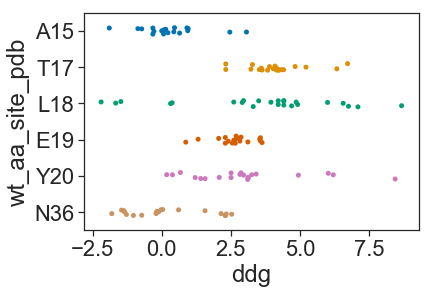

In [18]:
data.sort_values('site_pdb', inplace=True)
sns.stripplot(y='wt_aa_site_pdb', x='ddg', data=data)

In [19]:
data[
    #(data['wt_aa'] == 'L') &
    (data['site_pdb'] == 18)
][['mut_pdb', 'ddg']].sort_values('ddg')

,mut_pdb,ddg
2285,LI18Y,-2.193998
2286,LI18W,-1.667334
2283,LI18F,-1.480774
3195,LI18M,0.319571
2276,LI18M,0.375308
2271,LI18C,2.605531
2280,LI18Q,2.912104
2282,LI18H,2.958805
2277,LI18N,3.310148
3251,LI18Q,3.507256


## Make a list of energy functions to test

I will make two new energy functions:
* beta16_plus_lj_changes
    * wts: fa_rep to 0.6191
    * flags: LJ flags copied from beta_jan22 (except flags for new atom types)
* beta_jan22_minus_lj_changes
    * wts: fa_rep to 0.55
    * flags: deleted all LJ flags

In [20]:
e_function_dict = {
    'beta16' : {
        'weights_file' : 'beta_nov16_cart',
        'flags_file' : None,
        'extra_args' : ['-beta_nov16_cart']
    },

    'beta16_cart' : {
        'weights_file' : \
            '/home/haddox/2019/optE_eval/data/beta_nov16_cart.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/flags_beta16',
        'extra_args' : []
    },
    'beta16_cart_plus_hpsc_lj_changes' : {
        'weights_file' : \
            '/home/haddox/2019/optE_eval/data/beta_nov16_cart_plus_lj_changes.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/beta16_plus_hpsc_lj_changes_flags',
        'extra_args' : []
    },
    
    'beta16.nostab-refit' : {
        'weights_file' : \
            '/home/haddox/2019/optE_eval/data/beta16.nostab-refit_cart.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/flags_beta16',
        'extra_args' : []
    },
    'beta_jan22' : {
        'weights_file' : \
            '/home/haddox/2019/optE_eval/data/beta_jan22_cart.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/beta_jan22_flags',
        'extra_args' : []
    },
    'beta16_plus_lj_changes' : {
        'weights_file' : \
            '/home/haddox/2019/optE_eval/data/beta16_plus_lj_changes.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/beta16_plus_lj_changes_flags',
        'extra_args' : []
    },
    'beta16_plus_hpsc_lj_changes' : {
        'weights_file' : \
            '/home/haddox/2019/optE_eval/data/beta16_plus_lj_changes.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/beta16_plus_hpsc_lj_changes_flags',
        'extra_args' : []
    },
    
    
    'beta_jan22_minus_lj_changes' : {
        'weights_file' : \
            '/home/haddox/2019/optE_eval/data/beta_jan22_minus_lj_changes.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/beta_jan22_minus_lj_changes_flags',
        'extra_args' : []
    },
    'HH_run19A_step266' : {
        'weights_file' : \
            '/home/haddox/2019/optE_eval/data/HH_run19A_weights_266.wts',
        'flags_file' :
            '/home/haddox/2019/optE_eval/data/HH_run19A_flags_266',
        'extra_args' : []
    },

}

## Pre-relax each PDB with each Rosetta energy function

In [21]:
resultsdir

'/net/scratch/haddox/2024/interface_cart_ddg_benchmark/results/'

In [22]:
# Define input variables
relax_app_path = '/home/haddox/Rosetta/main/source/bin/relax.default.linuxgccrelease'
relax_space = 'cartesian' # 'dualspace' # 
relax_script = 'MonomerDesign2019'
e_functions = [
    'beta16_cart',
    'beta16_cart_plus_hpsc_lj_changes',
    # 'beta16',
    # 'beta16.nostab-refit',
    # 'beta_jan22',
    # 'beta16_plus_lj_changes',
    # 'beta16_plus_hpsc_lj_changes',
    # 'beta_jan22_minus_lj_changes',
    # 'HH_run19A_step266'
]

# Relax each native PDB chain with each energy function
njobs = 0
for pdb in pdbs_to_analyze:

    # if pdb not in ['1AK4_A_D']: # ['3BT1_A_U', '1A22_A_B', '1CHO_EFG_I']:
    #     continue
    
    pdb_code = pdb[:4]
    input_pdb = f'data/skempi_v2_pdbs/{pdb_code}.pdb'
    for e_function in e_functions:
        weights_file = e_function_dict[e_function]['weights_file']
        flags_file = e_function_dict[e_function]['flags_file']
        extra_args = list(e_function_dict[e_function]['extra_args'])
        extra_args += [
            '-nstruct 5',
            '-relax:constrain_relax_to_start_coords',
            '-relax:ramp_constraints false',
            '-relax:coord_constrain_sidechains',
            '-crystal_refine',
        ]

        output_dir = os.path.join(
            resultsdir,
            'relax_native/',
            os.path.basename(input_pdb).replace('.pdb', ''),
            f'{e_function}/'
        )
        scores_file_prefix = os.path.join(output_dir, 'relax')
        if not os.path.isdir(output_dir):
            print(
                os.path.basename(input_pdb).replace('.pdb', ''),
                e_function
            )
            os.makedirs(output_dir)
            design_utils.relax_design(
                relax_app_path=relax_app_path,
                input_pdbs=[input_pdb],
                weights_file=weights_file,
                results_dir=output_dir,
                scores_file_prefix=scores_file_prefix,
                relax_space=relax_space,
                relax_script=relax_script,
                extra_args=extra_args,
                flags_file=flags_file,
                submit_sbatch_job=True,
                queue_type='cpu',
                memory='2g',
            )
            # raise ValueError('test2')
            njobs += 1
            if njobs > 103:
                raise ValueError('test')

For each native, read in scores of replicate relaxes and choose the replicate with the best score for downstream analysis.

In [23]:
best_input_pdbs_across_reps_dict = {}

e_functions = [
    'beta16_cart',
    'beta16_cart_plus_hpsc_lj_changes',
]

for pdb in pdbs_to_analyze:
    
    # if pdb not in ['3BT1_A_U', '1A22_A_B', '1CHO_EFG_I']:
    #     continue
    
    input_pdb_code = pdb[:4]
    input_pdb = f'data/skempi_v2_pdbs/{input_pdb_code}.pdb'
    best_input_pdbs_across_reps_dict[input_pdb_code] = {}
    
    for e_function in e_functions:

        # Get score file for energy function
        score_file = os.path.join(
            resultsdir,
            'relax_native',
            input_pdb_code,
            e_function,
            'relax.sc'
        )
        if not os.path.isfile(score_file):
            # print(score_file)
            continue
        df = pd.read_csv(score_file, sep='\s+', skiprows=1)

        # Identify the relaxed pdb with the best score
        if False:
            print(
                input_pdb_code,
                e_function,
                len(df),
                round(df['total_score'].min(), 2),
                round(df['total_score'].max(), 2),
                round(df['ref'].min(), 2),
                round(df['ref'].max(), 2),
            )
        df.sort_values('total_score', ascending=True, inplace=True)
        best_score = df['total_score'].iloc[0]
        best_pdb = df['description'].iloc[0] + '.pdb'
        assert os.path.isfile(best_pdb), best_pdb
        best_input_pdbs_across_reps_dict[input_pdb_code][e_function] = best_pdb

## Use the `cartesian_ddg` application to predict the effect of each mutation

In [24]:
pdb = '1AK4_A_D' # '1BP3_A_B' # 

assert pdb in muts_to_analyze

input_pdb_code = pdb[:4]
# clean_input_pdb = f'data/skempi_v2_pdbs/{input_pdb_code}.pdb'

e_function = 'beta16_cart'
input_pdb = best_input_pdbs_across_reps_dict[input_pdb_code][e_function]
input_pdb = '/net/scratch/haddox/2024/interface_cart_ddg_benchmark/results/relax_native/1AK4/beta16_cart/1AK4_0005.pdb'

pose = pyrosetta.pose_from_pdb(input_pdb)

# Make a dictory that converts from a chain and residue number from the skempi
# mutation system to sequential numbering of the structre in Rosetta
skempi_to_rosetta_numbering = {}
for res_n in range(1, pose.size() + 1):
    chain = pose.pdb_info().chain(res_n)
    pdb_res_n = pose.pdb_info().number(res_n)
    # print(res_n, chain, pdb_res_n, pose.residue(res_n).name())
    skempi_to_rosetta_numbering[(chain, pdb_res_n)] = res_n

data = ddg_df[
    (ddg_df['pdb'] == pdb)
][['site', 'wt_aa', 'mut_aa', 'mut', 'cartddg_chain_and_jump_n']].drop_duplicates().copy()
data.sort_values('site', inplace=True)
for (i, row) in data.iterrows():
    site = row['site']
    wt_aa = row['wt_aa']
    mut_aa = row['mut_aa']
    mut_id = row['mut']
    mut_chain = mut_id[1]
    (chain_n, jump_n) = row['cartddg_chain_and_jump_n']

    if mut_id not in muts_to_analyze[pdb]:
        continue

    # Get the number of the mutant site in sequential numbering
    # starting with the first chain in the pose
    chain_start = pose.conformation().chain_begin(chain_n)
    sequential_site_n = chain_start + site - 1
    rosetta_res_n = skempi_to_rosetta_numbering[(mut_chain, site)]
    print(mut_id, mut_chain, rosetta_res_n, pose.residue(rosetta_res_n).name1())
    assert pose.residue(rosetta_res_n).name1() == wt_aa

PD85A D 232 P
AD92V D 239 A
PD93A D 240 P


Make one input file per mutant, and then carry out the protocol for each mutant.

In [25]:
print(len(pdbs_to_analyze))
passing_pdbs = [pdb for pdb in pdbs_to_analyze if pdb not in problem_pdbs]
print(len(passing_pdbs))
passing_pdbs

102
72


['3BT1_A_U',
 '1A22_A_B',
 '1CHO_EFG_I',
 '1R0R_E_I',
 '3SGB_E_I',
 '1PPF_E_I',
 '3S9D_A_B',
 '1JTG_A_B',
 '3HFM_HL_Y',
 '3MZG_A_B',
 '1LFD_A_B',
 '1GC1_G_C',
 '1VFB_AB_C',
 '1BP3_A_B',
 '4RS1_A_B',
 '1BRS_A_D',
 '1C4Z_ABC_D',
 '4G0N_A_B',
 '1EMV_A_B',
 '2WPT_A_B',
 '1CBW_FGH_I',
 '2JEL_LH_P',
 '1IAR_A_B',
 '1JTD_A_B',
 '2FTL_E_I',
 '1A4Y_A_B',
 '2G2U_A_B',
 '1FSS_A_B',
 '1KTZ_A_B',
 '1DQJ_AB_C',
 '3QHY_A_B',
 '4I77_HL_Z',
 '1B41_A_B',
 '1FC2_C_D',
 '1TM1_E_I',
 '1E50_A_B',
 '3SZK_AB_C',
 '1EAW_A_B',
 '3M62_A_B',
 '3NCB_A_B',
 '1JCK_A_B',
 '1FFW_A_B',
 '1K8R_A_B',
 '1XD3_A_B',
 '3SE4_B_A',
 '3SE4_B_C',
 '1Z7X_W_X',
 '3SE3_B_A',
 '2J0T_A_D',
 '1AK4_A_D',
 '5M2O_A_B',
 '1C1Y_A_B',
 '5F4E_A_B',
 '1KNE_A_P',
 '3BK3_A_C',
 '1N8Z_AB_C',
 '1GUA_A_B',
 '4BFI_A_B',
 '1F47_A_B',
 '2AJF_A_E',
 '5XCO_A_B',
 '3M63_A_B',
 '3AAA_AB_C',
 '3EQY_A_C',
 '1MLC_AB_E',
 '4OFY_A_D',
 '3Q8D_A_E',
 '3F1S_A_B',
 '3EQS_A_B',
 '3N0P_A_B',
 '2SIC_E_I',
 '3N06_A_B']

Checked:
* 3BT1_A_U
* 1A22_A_B
* 1CHO_EFG_I
* 3AAA_AB_C

In [26]:
# Define e functions to analyze
e_functions = [
    'beta16_cart',
    'beta16_cart_plus_hpsc_lj_changes',
    # 'beta16',
    # #'beta16.nostab-refit',
    # 'beta_jan22',
    # 'beta16_plus_lj_changes',
    # 'beta16_plus_hpsc_lj_changes',
    # # 'beta_jan22_minus_lj_changes',
    # 'HH_run19A_step266'
]

# Define the path to the ddG application and database
cartesian_ddg_path = '/home/haddox/Rosetta/main/source/bin/cartesian_ddg.default.linuxgccrelease'
databasepath = '/home/haddox/Rosetta/main/database/'

# Define inputs for ddG application
relax_space_name = 'cartesian' #'dualspace' #'torsion'
n_ddg_iterations = 3
dump_pdbs = True
bb_dof = 1
cwd = os.getcwd().replace('/mnt/', '/')
aas = Bio.Alphabet.IUPAC.IUPACProtein().letters

# Cycle over input PDBs and energy functions
n_jobs_submitted = 0
n_analyzed = 0
for pdb in pdbs_to_analyze:
    
    continue
    
    if pdb in [
        '2FTL_E_I', # '1DAN_HL_UT', '5C6T_HL_A', '1KNE_A_P', #'4RS1_A_B', '4NKQ_C_AB', '3BN9_B_CD',
        #'4P5T_CD_AB', '4P23_CD_AB', '3C60_CD_AB', '2FTL_E_I', '2NYY_DC_A', '3NPS_A_BC'
    ]:
        continue
    if pdb not in muts_to_analyze:
        continue

    input_pdb_code = pdb[:4]
    # if input_pdb_code != '3SE8':
    #     continue

    for e_function in e_functions:

        # Get files for energy funciton
        if e_function not in best_input_pdbs_across_reps_dict[input_pdb_code]:
            continue
        weights_file = e_function_dict[e_function]['weights_file']
        flags_file = e_function_dict[e_function]['flags_file']
        extra_args = list(e_function_dict[e_function]['extra_args'])
        input_pdb = best_input_pdbs_across_reps_dict[input_pdb_code][e_function]
        pose = pyrosetta.pose_from_pdb(input_pdb)
        
        # Make a dictory that converts from a chain and residue number from the skempi
        # mutation system to sequential numbering of the structre in Rosetta
        skempi_to_rosetta_numbering = {}
        protein_res_n = 1
        for res_n in range(1, pose.size() + 1):
            res = pose.residue(res_n)
            if res.is_protein():
                chain = pose.pdb_info().chain(res_n)
                pdb_res_n = pose.pdb_info().number(res_n)
                # print(res_n, chain, pdb_res_n, pose.residue(res_n).name())
                # skempi_to_rosetta_numbering[(chain, pdb_res_n)] = res_n
                skempi_to_rosetta_numbering[(chain, pdb_res_n)] = (res_n, protein_res_n)
                protein_res_n += 1
                
        # Get data for a specific PDB and then run the ddG computation
        # on each mutation
        #pdb = '1CHO_EFG_I' # '1CHO_EFG_I' # '1R0R_E_I' # '3SGB_E_I' # '1AO7_ABC_DE' # 
        data = ddg_df[
            (ddg_df['pdb'] == pdb)
        ][['site', 'wt_aa', 'mut_aa', 'mut', 'cartddg_chain_and_jump_n']].drop_duplicates().copy()
        data.sort_values('site', inplace=True)
        
        raise ValueError('test')
        
        for (i, row) in data.iterrows():
            site = row['site']
            wt_aa = row['wt_aa']
            mut_aa = row['mut_aa']
            mut_id = row['mut']
            mut_chain = mut_id[1]
            (chain_n, jump_n) = row['cartddg_chain_and_jump_n']
            
            # print(pdb, mut_id)
            # fold_tree = pose.fold_tree()
            # chain_begin = pose.chain_begin(jump_n + 1)
            # refine_jump_num = fold_tree.get_jump_that_builds_residue(chain_begin)
            # print(jump_n, chain_begin, refine_jump_num)
            # raise ValueError('test')
            
            if mut_id not in muts_to_analyze[pdb]:
                continue
                
            # Define the output directory
            output_dir = os.path.join(
                resultsdir,
                'cartesian_ddg',
                input_pdb_code,
                e_function,
                f'{mut_id}/'
            )
            if not os.path.isdir(output_dir):
                os.makedirs(output_dir)
            else:
                continue

            # Get the number of the mutant site in sequential numbering
            # starting with the first chain in the pose
            # chain_start = pose.conformation().chain_begin(chain_n)
            # sequential_site_n = chain_start + site - 1
            if (mut_chain, site) not in skempi_to_rosetta_numbering:
                print("missing", (mut_chain, site))
                continue
            (sequential_site_n, sequential_protein_site_n) = skempi_to_rosetta_numbering[(mut_chain, site)]
            assert pose.residue(sequential_site_n).name1() == wt_aa
            
            # Make an input file with information on a mutation,
            # using sequential numbering from the ddg_df that starts at
            # the beginning of the chain (for bookkeeping), but using
            # sequential numbering starting at the beginning of the pose
            # for input to Rosetta
            mutant_name = mut_id # f'{wt_aa}{site}{mut_aa}'
            mut_file = os.path.join(output_dir, f'{mutant_name}.txt')
            if not os.path.isfile(mut_file):
                with open(mut_file, 'w') as f:
                    f.write('total 1\n')
                    f.write('1\n')
                    # f.write(f'{wt_aa} {sequential_site_n} {mut_aa}\n')
                    f.write(f'{wt_aa} {sequential_protein_site_n} {mut_aa}\n')

            # Make the command-line argument
            scores_file_prefix = os.path.join(output_dir, mutant_name)
            cmd = ' '.join([
                cartesian_ddg_path,
                '-database {0}'.format(databasepath),
                '-s {0}'.format(os.path.join(cwd, input_pdb)),
                '-ddg:mut_file {0}'.format(os.path.join(cwd, mut_file)),
                '-ddg::interface_ddg {0}'.format(jump_n),
                '-ddg:iterations {0}'.format(n_ddg_iterations),
                '-ddg::cartesian',
                '-ddg::dump_pdbs {0}'.format(dump_pdbs),
                '-ddg:bbnbrs {0}'.format(bb_dof),
                '-ddg::legacy false',
                '-out:prefix {0}'.format(os.path.join(cwd, output_dir)),
                '-out:file:scorefile {0}.sc'.format(
                    os.path.join(cwd, scores_file_prefix)
                ),
                '-score:weights {0}'.format(weights_file),
                # '-crystal_refine',
                '-read_only_ATOM_entries'
            ])

            # Add extra aguments if appropriate
            if extra_args:
                for arg in extra_args:
                    cmd += ' {0}'.format(arg)

            # If `flags_file` is provided, add it to the command
            if flags_file:
                cmd += ' @{0}'.format(flags_file)

            # Write an sbatch file to carry out the command
            sbatch_file_name = os.path.join(
                cwd,
                '{0}.sbatch'.format(scores_file_prefix)
            )
            if not os.path.isfile(sbatch_file_name):
                print(pdb, mut_id)
                # print(sbatch_file_name)
                design_utils.WriteSbatchFile(
                    sbatch_file_name,
                    command=cmd,
                    queue_type='cpu',
                    memory='2g'
                )
                cmd = ['sbatch', sbatch_file_name]
                process = subprocess.Popen(
                    cmd, stdout=subprocess.PIPE,
                    cwd=output_dir
                )
                # raise ValueError(sbatch_file_name)
                n_jobs_submitted += 1
                if n_jobs_submitted > 50:
                    raise ValueError('limit n jobs')
    #raise ValueError('one pdb')

In [27]:
print('hi')

hi


Read in scores from `cartesian_ddg` protocol

In [28]:
ddg_scores_dict = defaultdict(list)
e_functions = [
    'beta16_cart',
    'beta16_cart_plus_hpsc_lj_changes',
]

# Iterate over input PDBs
for pdb in pdbs_to_analyze:

    if pdb in problem_pdbs:
        continue
    
    if pdb not in muts_to_analyze:
        continue
    
    # print('pdb:', pdb)
    
    input_pdb_code = pdb[:4]
    input_pdb = f'data/skempi_v2_pdbs/{input_pdb_code}.pdb'
    
    # Iterate over energy functions
    for e_function in e_functions:
        output_dir = os.path.join(
            resultsdir,
            'cartesian_ddg',
            input_pdb_code,
            f'{e_function}/'
        )
        ddg_fs = glob.glob(os.path.join(output_dir, '*/*.ddg'))
        # print(input_pdb_code, len(ddg_fs), e_function)

        if len(ddg_fs) == 0:
            # print(f'Missing files for energy function {e_function}')
            continue
        # if len(ddg_fs) < 20:
        #     continue
        
        # Read in data
        skip = False
        for ddg_f in ddg_fs:

            with open(ddg_f) as f:
                lines = f.readlines()
                if len(lines) < 18:
                    continue

            for wt_or_mut in ['wt', 'mut']:

                complex_scores = []
                apart_scores = []

                for line in lines:

                    # Search for complex scores
                    complex_pattern = r'COMPLEX:   Round\d: {0}\w+:\s+(?P<complex_score>-*\d+.\d+)'.format(wt_or_mut.upper())
                    match = re.search(complex_pattern, line)
                    if match:
                        complex_scores.append(float(match.group('complex_score')))

                    # Search for apart scores
                    apart_pattern = r'OPT_APART: Round\d: {0}\w+:\s+(?P<apart_score>-*\d+.\d+)'.format(wt_or_mut.upper())
                    match = re.search(apart_pattern, line)
                    if match:
                        apart_scores.append(float(match.group('apart_score')))


                if (len(complex_scores) != 3) or (len(apart_scores) != 3):
                    print('N replicates != 3 for', ddg_f)
                    skip = True
                    continue

                if skip:
                    continue
                ddg_scores_dict[f'{wt_or_mut}_complex'].append(np.mean(complex_scores))
                ddg_scores_dict[f'{wt_or_mut}_apart'].append(np.mean(apart_scores))
                ddg_scores_dict[f'{wt_or_mut}_complex_min'].append(np.min(complex_scores))
                ddg_scores_dict[f'{wt_or_mut}_apart_min'].append(np.min(apart_scores))

            ddg_scores_dict['pdb_id'].append(input_pdb_code)
            ddg_scores_dict['e_function'].append(e_function)
            ddg_scores_dict['mut'].append(
                os.path.basename(ddg_f).replace('.ddg', '')
            )

cart_ddg_df = pd.DataFrame(ddg_scores_dict)

# Compute dG for wt and mut, then ddG
cart_ddg_df['dg_wt'] = cart_ddg_df['wt_complex'] - cart_ddg_df['wt_apart']
cart_ddg_df['dg_mut'] = cart_ddg_df['mut_complex'] - cart_ddg_df['mut_apart']
cart_ddg_df['ddg'] = cart_ddg_df['dg_mut'] - cart_ddg_df['dg_wt']

print(len(cart_ddg_df))
cart_ddg_df.head()

1306


,wt_complex,wt_apart,wt_complex_min,wt_apart_min,mut_complex,mut_apart,mut_complex_min,mut_apart_min,pdb_id,e_function,mut,dg_wt,dg_mut,ddg
0,13210.149333,13271.849000,13209.784,13271.648,13212.436333,13274.974667,13212.346,13274.800,3BT1,beta16_cart,DU11A,-61.699667,-62.538333,-0.838667
1,13186.186667,13244.112333,13186.185,13244.085,13187.991000,13245.739333,13187.843,13245.732,3BT1,beta16_cart,AU253S,-57.925667,-57.748333,0.177333
2,13176.981000,13242.930000,13176.981,13242.930,13187.037667,13252.996000,13187.029,13252.945,3BT1,beta16_cart,GU197A,-65.949000,-65.958333,-0.009333
3,13169.736000,13230.007667,13169.724,13229.996,13173.121333,13233.938000,13173.115,13233.933,3BT1,beta16_cart,YU147A,-60.271667,-60.816667,-0.545000
4,13189.107000,13249.902333,13189.107,13249.899,13202.045000,13257.059333,13202.045,13257.059,3BT1,beta16_cart,LU148A,-60.795333,-55.014333,5.781000


In [35]:
cart_ddg_df.to_csv('results/computed_ddg_values.csv', index=False)

In [36]:
cart_ddg_df['pdb_id'].nunique()

62

In [37]:
len(cart_ddg_df.drop_duplicates(subset=['mut', 'pdb_id']))

646

In [38]:
cart_data = cart_ddg_df.pivot_table(index=['pdb_id', 'mut'], columns='e_function', values='ddg')
cart_data.reset_index(inplace=True)
print(len(cart_data))
cart_data.head()

646


e_function,pdb_id,mut,beta16_cart,beta16_cart_plus_hpsc_lj_changes
0,1A22,DB85A,0.812667,-1.165000
1,1A22,EA56A,2.136667,0.044667
2,1A22,EA65A,-3.314000,0.825333
3,1A22,EB10A,-4.021000,-4.421000
4,1A22,EB164A,0.903000,-0.068000


In [47]:
groupby_cols = [
    'pdb_id', 'mut', 'mut_pdb', 'site', 'site_pdb', 'wt_aa', 'mut_aa', 'loc',
    'wt_aa_is_polar', 'mut_aa_is_polar', 'involves_polar', 'mut_category'
]
all_data = ddg_df.groupby(groupby_cols)[['ddg']].mean().reset_index().merge(
    cart_data, on=['pdb_id', 'mut'], how='inner'
).sort_values('ddg')
all_data = all_data[
    (all_data['beta16_cart'].notnull()) &
    (all_data['beta16_cart_plus_hpsc_lj_changes'].notnull()) &
    (all_data['ddg'].notnull())
]
print(len(all_data))
all_data = all_data.dropna(subset=['beta16_cart', 'beta16_cart_plus_hpsc_lj_changes'])
print(len(all_data), all_data['pdb_id'].nunique())
all_data.to_csv('results/computed_and_experimental_ddg_values.csv', index=False)
all_data.head()

633
633 62


,pdb_id,mut,mut_pdb,site,site_pdb,wt_aa,mut_aa,loc,wt_aa_is_polar,mut_aa_is_polar,involves_polar,mut_category,ddg,beta16_cart,beta16_cart_plus_hpsc_lj_changes
274,1PPF,NI36D,NI36D,36,36,N,D,RIM,True,True,True,polar_to_polar,-3.034966,0.415000,0.275000
85,1CBW,KI15Y,KI15Y,15,15,K,Y,COR,True,False,True,polar_to_nonpolar,-2.613456,-5.958000,-6.911000
84,1CBW,KI15W,KI15W,15,15,K,W,COR,True,False,True,polar_to_nonpolar,-2.434919,-1.032000,-0.951000
191,1JTG,DB163K,DB163K,163,163,D,K,RIM,True,True,True,polar_to_polar,-1.981674,-1.387333,-1.797333
283,1PPF,PI14W,PI14W,14,14,P,W,RIM,False,False,False,nonpolar_to_nonpolar,-1.977015,-7.124000,-7.530000


633
R = 0.595


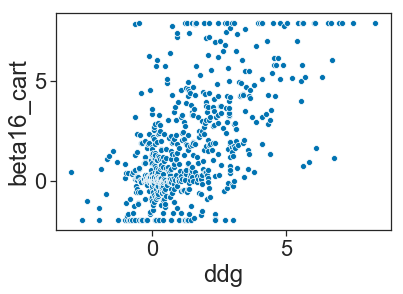

R = 0.58


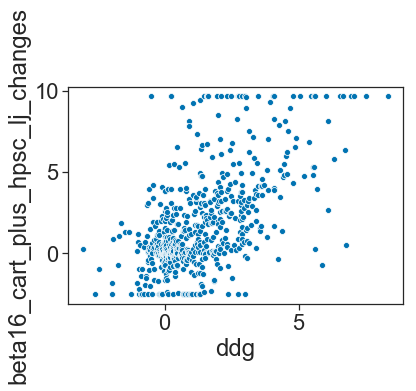

In [40]:
pdbs_of_interest = ['3BT1', '1A22', '1CHO']
data = all_data[
    # (all_data['pdb_id'] == '1CHO') &
    # (all_data['pdb_id'].isin(pdbs_to_plot)) &
    # (all_data['pdb_id'].isin(pdbs_of_interest)) &
    # (all_data['loc'] == 'COR') &
    # (all_data['involves_polar'] == True) &
    # (all_data['mut_aa_is_polar'] == True) &
    # (all_data['wt_aa_is_polar'] == True) &
    (all_data['ddg'].notnull())
].copy()
print(len(data))
for e_function in e_functions:
    data[e_function] = data[e_function].clip(
        lower=data[e_function].quantile(0.05),
        upper=data[e_function].quantile(0.95)
    )
    (r, p) = scipy.stats.pearsonr(data['ddg'], data[e_function])
    print(f'R = {round(r, 3)}')
    sns.scatterplot(x='ddg', y=e_function, data=data)
    plt.show()

In [41]:
import numpy as np
from scipy.stats import chi2
from statsmodels.stats.contingency_tables import mcnemar

In [42]:
def classify_mut_effect(effect, cutoff=1):
    if effect < -cutoff:
        return 'stablizing'
    elif effect > cutoff:
        return 'destabilizing'
    else:
        return 'neutral'

# Get data for balanced ids
data = all_data[
    (all_data['ddg'].notnull())
].copy()

# Classify mut effects
effect_cols = ['beta16_cart', 'beta16_cart_plus_hpsc_lj_changes', 'ddg']
for col in effect_cols:
    data[f'{col}_class'] = data[col].apply(lambda x: classify_mut_effect(x))
for col in effect_cols:
    data[f'{col}_correct'] = data[f'{col}_class'] == data['ddg_class']

for e_function in e_functions:
    n_correct = sum(data[f'{e_function}_correct'])
    print(e_function, n_correct, len(data), n_correct/len(data))
    
data.head()

beta16_cart 408 633 0.6445497630331753
beta16_cart_plus_hpsc_lj_changes 415 633 0.655608214849921


,pdb_id,mut,mut_pdb,site,site_pdb,wt_aa,mut_aa,loc,wt_aa_is_polar,mut_aa_is_polar,involves_polar,ddg,beta16_cart,beta16_cart_plus_hpsc_lj_changes,beta16_cart_class,beta16_cart_plus_hpsc_lj_changes_class,ddg_class,beta16_cart_correct,beta16_cart_plus_hpsc_lj_changes_correct,ddg_correct
274,1PPF,NI36D,NI36D,36,36,N,D,RIM,True,True,True,-3.034966,0.415000,0.275000,neutral,neutral,stablizing,False,False,True
85,1CBW,KI15Y,KI15Y,15,15,K,Y,COR,True,False,True,-2.613456,-5.958000,-6.911000,stablizing,stablizing,stablizing,True,True,True
84,1CBW,KI15W,KI15W,15,15,K,W,COR,True,False,True,-2.434919,-1.032000,-0.951000,stablizing,neutral,stablizing,True,False,True
191,1JTG,DB163K,DB163K,163,163,D,K,RIM,True,True,True,-1.981674,-1.387333,-1.797333,stablizing,stablizing,stablizing,True,True,True
283,1PPF,PI14W,PI14W,14,14,P,W,RIM,False,False,False,-1.977015,-7.124000,-7.530000,stablizing,stablizing,stablizing,True,True,True


In [43]:
# Create contingency table
# Count cases where:
both_correct = np.sum(data['beta16_cart_correct'] & data['beta16_cart_plus_hpsc_lj_changes_correct'])
beta_nov16_only = np.sum(data['beta16_cart_correct'] & ~data['beta16_cart_plus_hpsc_lj_changes_correct'])
beta_jan25_only = np.sum(~data['beta16_cart_correct'] & data['beta16_cart_plus_hpsc_lj_changes_correct'])
both_wrong = np.sum(~data['beta16_cart_correct'] & ~data['beta16_cart_plus_hpsc_lj_changes_correct'])

# McNemar's test focuses on discordant pairs
contingency_table = np.array([[both_correct, beta_nov16_only],
                             [beta_jan25_only, both_wrong]])
contingency_table

array([[371,  37],
       [ 44, 181]])

In [44]:
# Perform McNemar's test
result = mcnemar(contingency_table, exact=False, correction=True)
print(f"McNemar's test statistic: {result.statistic}")
print(f"p-value: {result.pvalue}")

McNemar's test statistic: 0.4444444444444444
p-value: 0.5049850750938457


To do:
* run the energy function on new docking test
    * decide how to present based on numbers
* run the whole skempi benchmark
* run the cart_ddg test on monomers

* could try porting over some LK changes
    * just port over params for atoms that are problematic in atom pair distributions
    * e.g., could just port over OCbb changes
    * could try shrinking CObb
* could try reverting some LJ changes or look at intermediate values
    * e.g., OCbb
* make sure that we don't worsen the other tests


* try 19A with full dataset
    * skempi
    * and for monomer ddg
    * if don't see worsening, can be pretty confident
* try top 10 most frequent PDBs
    * saw close to 0.7 in past
    * could change bb_nbrs to 0 instead of 1
* subsets of mutations
    * separately report alanine vs. non-alanine mutations
* what's going on with the point that's -20?
    * is the pre-relax failing in some cases? look for error messages in relax or ddg application (relax aborted at iteration x?)

* focus on things where alpha fold doesn't work very well
    * like skempi
    * like monomer ddg

* pros
    * simpler
    * clearer story
* cons
    * beta_jan22 is good to go
    * lj variant might need some additional tuning? does it perform well on benchmarks?

* undo DGFREE changes -> is there something silly going on?
* run test with the previous LJ energy function -> does it make things better?
* try LJ energy function with monomer ddG
* just write up LJ changes?

Classify mutations as stabilizing (>1), destabilizing (<-1), neutral (+/- 1; or 2)

In [126]:
cutoff = 1
class_dict = {
    key : []
    for key in [
        'e_function',
        'true_stab', 'false_stab_neu', 'false_stab_de',
        'true_neu', 'false_neu_stab', 'false_neu_de',
        'true_de', 'false_de_neu', 'false_de_stab'
    ]
}
e_functions = [
    'beta16_cart',
    'beta16_cart_plus_hpsc_lj_changes',
    # 'beta16',
    # #'beta16.nostab-refit',
    # 'beta_jan22',
    # 'beta16_plus_lj_changes',
    # 'beta16_plus_hpsc_lj_changes',
    # # 'beta_jan22_minus_lj_changes',
    # 'HH_run19A_step266'
]

pdbs_of_interest = ['3BT1', '1A22', '1CHO']
data = all_data[
    # (all_data['pdb_id'] == '1CHO') &
    # (all_data['pdb_id'].isin(pdbs_to_plot)) &
    # (all_data['pdb_id'].isin(pdbs_of_interest)) &
    # (all_data['loc'] == 'COR') &
    # (all_data['involves_polar'] == True) &
    # (all_data['mut_aa_is_polar'] == True) &
    # (all_data['wt_aa_is_polar'] == True) &
    (all_data['ddg'].notnull())
].copy()

for e_function in e_functions:

    # Record data
    class_dict['e_function'].append(e_function)

    class_dict['true_stab'].append(sum(
        (data['ddg'] < -cutoff) & (data[e_function] < -cutoff)
    ))
    class_dict['false_stab_neu'].append(sum(
        (data['ddg'].between(-cutoff, cutoff)) & (data[e_function] < -cutoff)
    ))
    class_dict['false_stab_de'].append(sum(
        (data['ddg'] > cutoff) & (data[e_function] < -cutoff)
    ))

    class_dict['true_neu'].append(sum(
        (data['ddg'].between(-cutoff, cutoff)) & (data[e_function].between(-cutoff, cutoff))
    ))
    class_dict['false_neu_stab'].append(sum(
        (data['ddg'] < -cutoff) & (data[e_function].between(-cutoff, cutoff))
    ))
    class_dict['false_neu_de'].append(sum(
        (data['ddg'] > cutoff) & (data[e_function].between(-cutoff, cutoff))
    ))
    
    class_dict['true_de'].append(sum(
        (data['ddg'] > cutoff) & (data[e_function] > cutoff)
    ))
    class_dict['false_de_neu'].append(sum(
        (data['ddg'].between(-cutoff, cutoff)) & (data[e_function] > cutoff)
    ))
    class_dict['false_de_stab'].append(sum(
        (data['ddg'] < -cutoff) & (data[e_function] > cutoff)
    ))

class_df = pd.DataFrame(class_dict)
class_df = class_df.set_index('e_function').T # / len(all_data)
class_df

e_function,beta16_cart,beta16_cart_plus_hpsc_lj_changes
true_stab,7,6
false_stab_neu,61,66
false_stab_de,25,24
true_neu,213,206
false_neu_stab,5,5
false_neu_de,71,72
true_de,213,213
false_de_neu,93,95
false_de_stab,2,3


In [127]:
class_df.sum()

e_function
beta16_cart                         690
beta16_cart_plus_hpsc_lj_changes    690
dtype: int64

In [29]:
# Classification accuracy of beta_nov16
print('N correct', (22 + 871 + 590))
print('N incorrect', 2415 - (22 + 871 + 590))
print('frac correct', (22 + 871 + 590) / 2415)

N correct 1483
N incorrect 932
frac correct 0.6140786749482402


In [30]:
print('N correct', (23 + 868 + 610))
print('N incorrect', 2415 - (23 + 868 + 610))
print('frac correct', (23 + 868 + 610) / 2415)

N correct 1501
N incorrect 914
frac correct 0.6215320910973084


In [31]:
# CH3 beta_nov16
2.012 * 0.063

0.126756

In [32]:
# CH3 beta_jan22
2.060 * 0.064

0.13184

In [33]:
# CH0 beta_nov_16
2.012 * 0.063

0.126756

In [34]:
# CH0 beta_jan22
2.040 * 0.075

0.153

In [88]:
cutoff = 1
class_dict = {
    key : []
    for key in [
        'e_function',
        'true_stab', 'false_stab_neu', 'false_stab_de',
        'true_neu', 'false_neu_stab', 'false_neu_de',
        'true_de', 'false_de_neu', 'false_de_stab'
    ]
}
e_functions = ['beta16', 'beta_jan22']
for e_function in e_functions:

    # Record data
    class_dict['e_function'].append(e_function)

    class_dict['true_stab'].append(sum(
        (all_data['ddg'] < -cutoff) & (all_data[e_function] < -cutoff)
    ))
    class_dict['false_stab_neu'].append(sum(
        (all_data['ddg'].between(-cutoff, cutoff)) & (all_data[e_function] < -cutoff)
    ))
    class_dict['false_stab_de'].append(sum(
        (all_data['ddg'] > cutoff) & (all_data[e_function] < -cutoff)
    ))

    class_dict['true_neu'].append(sum(
        (all_data['ddg'].between(-cutoff, cutoff)) & (all_data[e_function].between(-cutoff, cutoff))
    ))
    class_dict['false_neu_stab'].append(sum(
        (all_data['ddg'] < -cutoff) & (all_data[e_function].between(-cutoff, cutoff))
    ))
    class_dict['false_neu_de'].append(sum(
        (all_data['ddg'] > cutoff) & (all_data[e_function].between(-cutoff, cutoff))
    ))
    
    class_dict['true_de'].append(sum(
        (all_data['ddg'] > cutoff) & (all_data[e_function] > cutoff)
    ))
    class_dict['false_de_neu'].append(sum(
        (all_data['ddg'].between(-cutoff, cutoff)) & (all_data[e_function] > cutoff)
    ))
    class_dict['false_de_stab'].append(sum(
        (all_data['ddg'] < -cutoff) & (all_data[e_function] > cutoff)
    ))

class_df = pd.DataFrame(class_dict)
class_df = class_df.set_index('e_function').T # / len(all_data)
class_df

e_function,beta16,beta_jan22
true_stab,22,31
false_stab_neu,206,206
false_stab_de,86,108
true_neu,874,874
false_neu_stab,31,18
false_neu_de,253,279
true_de,590,542
false_de_neu,340,340
false_de_stab,16,20


In [86]:
class_df.sum()

e_function
beta16        2418
beta_jan22    2418
dtype: int64

Group things together

In [75]:
e_function = 'beta_jan22'
all_data[
    (all_data['ddg'].between(-cutoff, cutoff)) & (all_data[e_function].between(-cutoff, cutoff))
]

,pdb_id,mut,mut_pdb,site,site_pdb,wt_aa,mut_aa,loc,wt_aa_is_polar,mut_aa_is_polar,involves_polar,ddg,beta16,beta_jan22
562,1CHO,PI11C,PI14C,11,14,P,C,RIM,False,False,False,-0.969812,-0.674,0.596
1199,1PPF,RI21F,RI21F,21,21,R,F,RIM,True,False,True,-0.967544,-1.594,0.377
1268,1R0R,AI10V,AI15V,10,15,A,V,COR,False,False,False,-0.956543,-1.734,-0.592
484,1CHO,GI29A,GI32A,29,32,G,A,SUP,False,False,False,-0.918710,0.324,0.780
9,1A22,EA163A,EA174A,163,174,E,A,COR,True,False,True,-0.909537,-1.433,0.751
1378,1R0R,PI9N,PI14N,9,14,P,N,RIM,False,True,True,-0.904549,-1.204,-0.432
1204,1PPF,RI21L,RI21L,21,21,R,L,RIM,True,False,True,-0.846596,-0.763,-0.637
571,1CHO,PI11M,PI14M,11,14,P,M,RIM,False,False,False,-0.816545,-0.002,0.631
1188,1PPF,PI14Q,PI14Q,14,14,P,Q,RIM,False,True,True,-0.799953,-0.277,-0.194
1202,1PPF,RI21I,RI21I,21,21,R,I,RIM,True,False,True,-0.799953,0.549,0.490


* try taking the median and the min
* try analyzing the change in total energy of the complex
* try classifying mutations: stabilizing, destabilizing, neutral (+/- 1 or 2)
* separate by source and target residue (one plot per) e.g., look at positive residues
* try turning off each set of changes, and see what breaks things (LJ vs nonLJ)
    * do the ablation experiments with the 3 or 4 structures with the most mutations

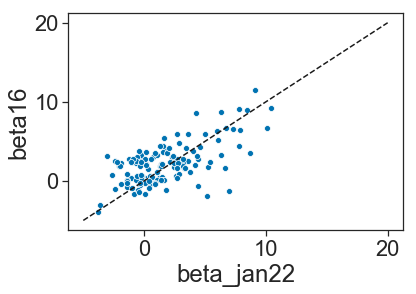

In [35]:
sns.scatterplot(x='beta_jan22', y='beta16',data=data)
plt.plot([-5,20], [-5,20], ls='--', c='k')
plt.show()

In [88]:
data[
    (data['ddg'] > 2) &
    (data['beta_jan22'] < 0) &
    (data['beta16'] > 0)
][['pdb_id', 'site', 'wt_aa', 'mut_aa', 'ddg', 'beta16', 'beta_jan22', 'mut_pdb']]

,pdb_id,site,wt_aa,mut_aa,ddg,beta16,beta_jan22,mut_pdb
479,1CHO,16,E,S,2.755332,0.839333,-1.369000,EI19S
632,1CHO,17,Y,R,2.868753,3.067667,-0.581333,YI20R
615,1CHO,14,T,V,3.379583,1.858000,-1.971333,TI17V
472,1CHO,16,E,K,3.544444,2.709667,-0.911333,EI19K
469,1CHO,16,E,G,3.572088,0.753667,-0.234000,EI19G
606,1CHO,14,T,I,3.600824,2.333000,-1.104000,TI17I
478,1CHO,16,E,R,3.630437,3.838333,-0.387667,EI19R
616,1CHO,14,T,W,4.100451,2.391667,-2.270333,TI17W


**Observations**:
* beta16 tends to perform better in all cross sections of the data that I've tested
    * overall
    * polar
    * core
    * pdbs with >100 measurements
    * single pdb with >200 measurements
    
* why is beta_jan22 doing worse?
    * in ICHO, when looking at polar/COR muts, it seems like there are more mutations with positive ddgs that have low or negative ddgs in beta_jan22
    * when looking at all muts, it seems like there are also more things with high predicted ddgs across a range of actual ddgs
    
    